In [1]:
import os
import sys
import glob
import random
import numpy as np
import pandas as pd

## Plotting Packages
import matplotlib as mpl
import matplotlib.pyplot as plt

## PyTorch Packages
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## TIMM for ML
import timm.layers as timmm 

## Lifelines for Time-To-Event Statistics
import lifelines

In [2]:
sys.path.insert(0, os.path.abspath('../modules/'))
from ViT_modules import T2T_ViT
from CNN_modules import CNN

In [3]:
def parse_dfs(directory: str,
              studyID: int,
              studies_df: pd.DataFrame,
              update_studies: bool=True,
              verbose: bool=True):

    ## Load in Study csvs
    study = 'study_{:02d}'.format(studyID)
    summary = 'study{:02d}_trainval_summary.csv'.format(studyID)
    testing = 'study{:02d}_testset_results.csv'.format(studyID)
    summary_path = os.path.join(directory, study, summary)
    summary_data = pd.read_csv(summary_path, index_col=0)

    ## Calculate Model Properties
    summary_data['cum_time'] = summary_data['epoch_time'].cumsum() / 60
    max_epoch = summary_data.index.max()
    train_time = summary_data.sum()['epoch_time'] / 60
    avg_train_time = ( train_time / max_epoch ) * 60
    if verbose: print('Model', studyID, 'took', round(train_time,2), 'hours to train', str(max_epoch), 'epochs,\naverage of', round(avg_train_time, 2) ,'min per epoch.')
    testing_path = os.path.join(directory, study, testing)
    test_data = pd.read_csv(testing_path, index_col=0)
    test_loss = test_data.mean()['loss']
    if verbose: print('Model', studyID, 'Average Loss on Test Set: {:e}'.format(test_loss))

    ## Update Studies Dataframe
    if update_studies:
        studies_df.loc[studyID, 'TOTAL_TIME (hr)'] = train_time
        studies_df.loc[studyID, 'AVG_EPOCH_TIME (min)'] = avg_train_time
        studies_df.loc[studyID, 'TEST_AVG'] = test_loss
    
    
    return summary_data, test_loss

In [4]:
threshold = 1e-3

## T2T-Model Reults

In [5]:
## Loading in the Empty Study Dataframe
directory = os.path.abspath('../T2T_ViT_Models')
t2t_studies = pd.read_csv(os.path.join(directory, 'hyperparameters.csv'), index_col=0, comment='#')
t2t_studies['TEST_AVG'] = ''
t2t_studies['TOTAL_TIME (hr)'] = '' #In hours
t2t_studies['AVG_EPOCH_TIME (min)'] = '' #In minutes
t2t_studies.drop('Unnamed: 1', axis=1, inplace=True) #handling that the csv only has one column

## Filling in Study Column info
for i, SID in enumerate(t2t_studies.index):
    _, _ = parse_dfs(directory=directory, studyID=SID, studies_df=t2t_studies, update_studies=True, verbose=False)

## Adding the Best Checkpoint and Checkpoint Test Accuracy
    ## This was calculated using the best_chkpoint_testing.py script, and results were copied here
t2t_studies['BEST_CHKPT'] = ''
t2t_studies['CHKPT_TEST'] = ''
t2t_studies['CHKPT_UNDER_THSHLD'] = ''
t2t_studies.loc[100, 'BEST_CHKPT'] = 500
t2t_studies.loc[100, 'CHKPT_TEST'] = 0.0002686036
t2t_studies.loc[101, 'BEST_CHKPT'] = 50
t2t_studies.loc[101, 'CHKPT_TEST'] = 0.2741445
t2t_studies.loc[102, 'BEST_CHKPT'] = 200
t2t_studies.loc[102, 'CHKPT_TEST'] = 0.17310597
t2t_studies.loc[103, 'BEST_CHKPT'] = 500
t2t_studies.loc[103, 'CHKPT_TEST'] = 0.00013302735
t2t_studies.loc[104, 'BEST_CHKPT'] = 100
t2t_studies.loc[104, 'CHKPT_TEST'] = 0.25568783
t2t_studies.loc[105, 'BEST_CHKPT'] = 400
t2t_studies.loc[105, 'CHKPT_TEST'] = 0.26258582
t2t_studies.loc[106, 'BEST_CHKPT'] = 400
t2t_studies.loc[106, 'CHKPT_TEST'] = 0.00017049903
t2t_studies.loc[107, 'BEST_CHKPT'] = 500
t2t_studies.loc[107, 'CHKPT_TEST'] = 0.00013925321
t2t_studies.loc[108, 'BEST_CHKPT'] = 300
t2t_studies.loc[108, 'CHKPT_TEST'] = 0.00029369525
t2t_studies.loc[109, 'BEST_CHKPT'] = 350
t2t_studies.loc[109, 'CHKPT_TEST'] = 0.2727822
t2t_studies.loc[110, 'BEST_CHKPT'] = 450
t2t_studies.loc[110, 'CHKPT_TEST'] = 0.23044468
t2t_studies.loc[111, 'BEST_CHKPT'] = 400
t2t_studies.loc[111, 'CHKPT_TEST'] = 0.00011243379
t2t_studies.loc[112, 'BEST_CHKPT'] = 500
t2t_studies.loc[112, 'CHKPT_TEST'] = 0.26411304
t2t_studies.loc[113, 'BEST_CHKPT'] = 450
t2t_studies.loc[113, 'CHKPT_TEST'] = 0.26603842
t2t_studies.loc[114, 'BEST_CHKPT'] = 100
t2t_studies.loc[114, 'CHKPT_TEST'] = 0.18772216
t2t_studies['CHKPT_UNDER_THSHLD'] = t2t_studies['CHKPT_TEST'] < threshold

## Calculated Time-To-Event for If Model Learned
t2t_studies['OCCURED'] = 0
t2t_studies['TTE'] = '' #time-to-event

for SID in t2t_studies.index:
    t2t_summary_data, _ = parse_dfs(directory=directory, studyID=SID, studies_df=t2t_studies, update_studies=False, verbose=False)
    t2t_summary_data['LEARNED'] = t2t_summary_data['val_loss'] < threshold
    
    learned_epoch=0
    epochs = t2t_summary_data.index[t2t_summary_data['LEARNED'] == True].tolist()
    for i, e in enumerate(epochs[:-2]):
        if epochs[i]+1==epochs[i+1] and epochs[i+1]+1==epochs[i+2]:
            learned_epoch = epochs[i+2]
            t2t_studies.loc[SID, 'OCCURED'] = 1
            t2t_studies.loc[SID, 'TTE'] = learned_epoch
            break
        else:
            pass
    if t2t_studies.loc[SID, 'OCCURED'] == 0:
        t2t_studies.loc[SID, 'TTE'] = t2t_summary_data.index.max()
        
t2t_studies

,TEST_AVG,TOTAL_TIME (hr),AVG_EPOCH_TIME (min),BEST_CHKPT,CHKPT_TEST,CHKPT_UNDER_THSHLD,OCCURED,TTE
studyIDX,,,,,,,,
100,0.000257,60.540292,7.264835,500,0.000269,True,1,163
101,0.266471,61.595816,7.391498,50,0.274145,False,0,500
102,0.289092,58.298867,6.995864,200,0.173106,False,0,500
103,0.000126,62.855666,7.54268,500,0.000133,True,1,142
104,0.267191,61.316812,7.358017,100,0.255688,False,0,500
105,0.257943,64.05107,7.686128,400,0.262586,False,0,500
106,0.000264,61.496246,7.37955,400,0.00017,True,1,320
107,0.000137,62.452299,7.494276,500,0.000139,True,1,156
108,0.000323,60.042286,7.205074,300,0.000294,True,1,207


In [6]:
t2t_argmin = np.argmin(t2t_studies['CHKPT_TEST'])
t2t_best = t2t_studies.iloc[t2t_argmin]
t2t_beststudyID = t2t_studies.index[t2t_argmin]
print('The best performing T2T-Vit Model was Study '+str(t2t_beststudyID)+',\nWhich achieved a  loss of {:e} at checkpoint {}.'.format(t2t_best.loc['CHKPT_TEST'], t2t_best.loc['BEST_CHKPT']))
t2t_studies.loc[t2t_beststudyID]

The best performing T2T-Vit Model was Study 111,
Which achieved a  loss of 1.124338e-04 at checkpoint 400.


TEST_AVG                 0.000179
TOTAL_TIME (hr)         59.920896
AVG_EPOCH_TIME (min)     7.190507
BEST_CHKPT                    400
CHKPT_TEST               0.000112
CHKPT_UNDER_THSHLD           True
OCCURED                         1
TTE                           193
Name: 111, dtype: object

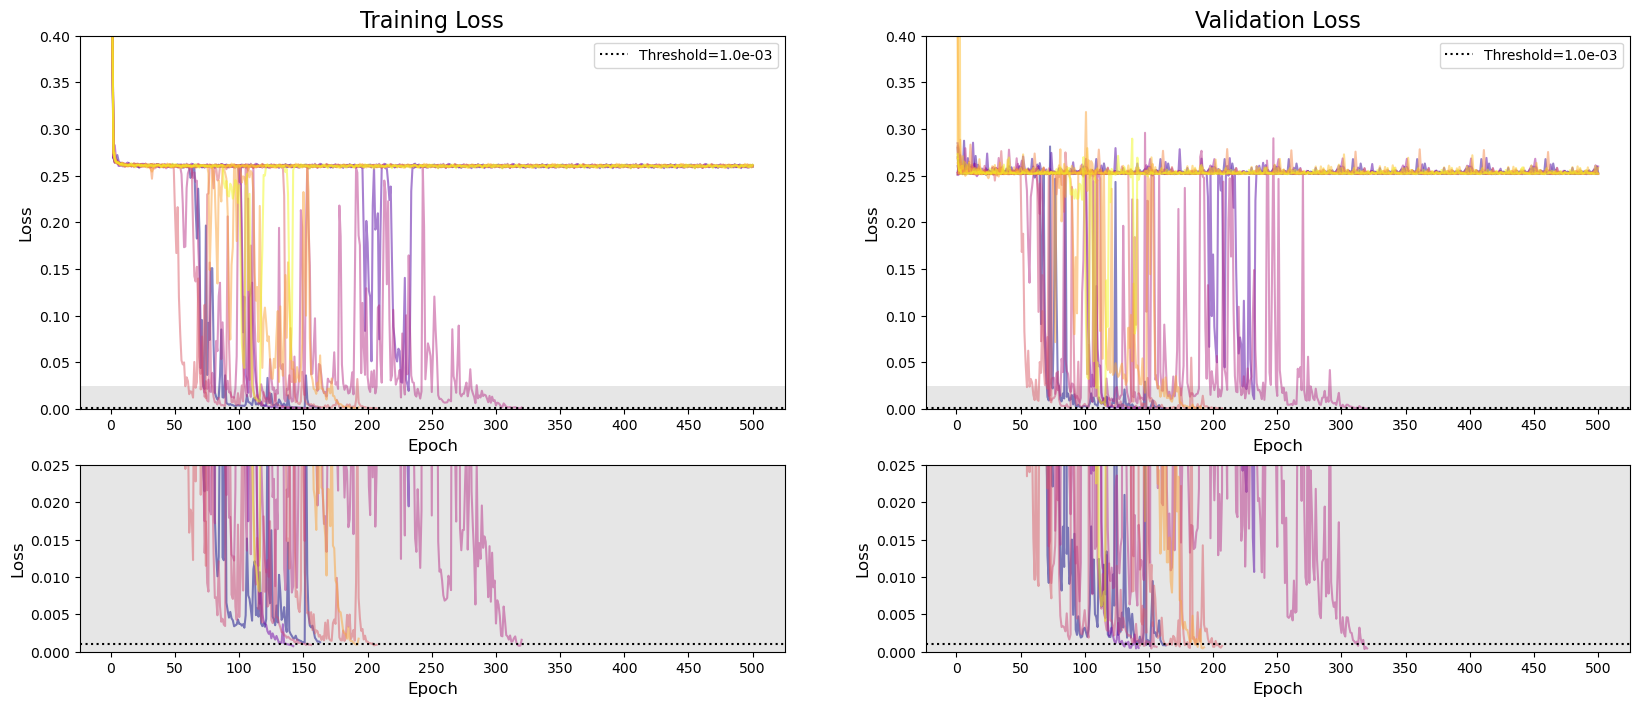

In [7]:
directory = os.path.abspath('../T2T_ViT_Models')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, height_ratios=[2, 1], figsize=(20, 8))
#fig.suptitle('T2T-ViT Identical Parameter Variance', fontsize=18)
colors = plt.get_cmap('plasma')
face_color = str(0.9)
plot_cutoff = 0.4
subplot_cuttoff = 0.025
spacing = np.linspace(0, 1, len(t2t_studies.index), endpoint=True)
total_max_epoch = 0

for i, SID in enumerate(t2t_studies.index):

    t2t_summary_data, _ = parse_dfs(directory=directory, studyID=SID, studies_df=t2t_studies, update_studies=False, verbose=False)
    
    study_max_epoch = t2t_summary_data.index.max()
    total_max_epoch = max(total_max_epoch, study_max_epoch)
    TTE_epoch = t2t_studies.loc[SID, 'TTE']
    ax1.plot(np.arange(1, TTE_epoch+1), t2t_summary_data['train_loss'][:TTE_epoch], alpha=0.5, color=colors(spacing[i]))
    ax2.plot(np.arange(1, TTE_epoch+1), t2t_summary_data['val_loss'][:TTE_epoch], alpha=0.5, color=colors(spacing[i]))

    ax3.plot(np.arange(1, TTE_epoch+1), t2t_summary_data['train_loss'][:TTE_epoch], alpha=0.5, color=colors(spacing[i]))
    ax4.plot(np.arange(1, TTE_epoch+1), t2t_summary_data['val_loss'][:TTE_epoch], alpha=0.5, color=colors(spacing[i]))


legend_elements = [mpl.lines.Line2D([0], [0], ls=':', color='k', alpha=1, label='Threshold={:.1e}'.format(threshold))]

ax1.set_title('Training Loss', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_xticks(np.arange(0, total_max_epoch+1, 50))
ax1.axhline(threshold, ls=':', color='k')
ax1.set_ylim([0, plot_cutoff])
ax1.legend(handles=legend_elements)
shaded_epochs = mpl.patches.Rectangle((-100, 0), total_max_epoch+200, subplot_cuttoff, facecolor=face_color)
ax1.add_patch(shaded_epochs)

ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Loss', fontsize=12)
ax3.set_xticks(np.arange(0, total_max_epoch+1, 50))
ax3.axhline(threshold, ls=':', color='k')
ax3.set_ylim([0, subplot_cuttoff])
ax3.set_facecolor(face_color)

ax2.set_title('Validation Loss', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_xticks(np.arange(0, total_max_epoch+1, 50))
ax2.axhline(threshold, ls=':', color='k')
ax2.set_ylim([0, plot_cutoff])
ax2.legend(handles=legend_elements)
shaded_epochs = mpl.patches.Rectangle((-100, 0), total_max_epoch+200, subplot_cuttoff, facecolor=face_color)
ax2.add_patch(shaded_epochs)

ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Loss', fontsize=12)
ax4.set_xticks(np.arange(0, total_max_epoch+1, 50))
ax4.axhline(threshold, ls=':', color='k')
ax4.set_ylim([0, subplot_cuttoff])
ax4.set_facecolor(face_color)
#fig.savefig('../figures/t2tvit_histories.png');

## CNN Model Results

In [8]:
directory = os.path.abspath('../CNN_Models')
cnn_studies = pd.read_csv(os.path.join(directory, 'hyperparameters.csv'), index_col=0, comment='#')
cnn_studies['TEST_AVG'] = ''
cnn_studies['TOTAL_TIME (hr)'] = '' #In hours
cnn_studies['AVG_EPOCH_TIME (min)'] = '' #In minutes
cnn_studies.drop((cnn_studies.index[cnn_studies['DEPTH']!=3].tolist()), inplace=True) #Remove the studies with nonstandard depth

## Filling in Study Column info
for i, SID in enumerate(cnn_studies.index):
    _, _ = parse_dfs(directory=directory, studyID=SID, studies_df=cnn_studies, update_studies=True, verbose=False)

## Adding the Best Checkpoint and Checkpoint Test Accuracy
    ## This was calculated using the best_chkpoint_testing.py script, and results were copied here
cnn_studies['BEST_CHKPT'] = ''
cnn_studies['CHKPT_TEST'] = ''
cnn_studies.loc[200, 'BEST_CHKPT'] = 200
cnn_studies.loc[200, 'CHKPT_TEST'] = 5.521546e-05
cnn_studies.loc[201, 'BEST_CHKPT'] = 250
cnn_studies.loc[201, 'CHKPT_TEST'] = 5.5945493e-05
cnn_studies.loc[202, 'BEST_CHKPT'] = 200
cnn_studies.loc[202, 'CHKPT_TEST'] = 0.00019758343
cnn_studies.loc[203, 'BEST_CHKPT'] = 100
cnn_studies.loc[203, 'CHKPT_TEST'] = 0.0009865667
cnn_studies.loc[204, 'BEST_CHKPT'] = 200
cnn_studies.loc[204, 'CHKPT_TEST'] = 0.00085906225
cnn_studies.loc[205, 'BEST_CHKPT'] = 200
cnn_studies.loc[205, 'CHKPT_TEST'] = 0.00036684374
cnn_studies.loc[206, 'BEST_CHKPT'] = 150
cnn_studies.loc[206, 'CHKPT_TEST'] = 0.000104943436
cnn_studies.loc[207, 'BEST_CHKPT'] = 200
cnn_studies.loc[207, 'CHKPT_TEST'] = 0.00024975126
cnn_studies.loc[208, 'BEST_CHKPT'] = 250
cnn_studies.loc[208, 'CHKPT_TEST'] = 0.00040813908
cnn_studies.loc[209, 'BEST_CHKPT'] = 150
cnn_studies.loc[209, 'CHKPT_TEST'] = 0.0004835391
cnn_studies.loc[210, 'BEST_CHKPT'] = 200
cnn_studies.loc[210, 'CHKPT_TEST'] = 0.0005732505
cnn_studies.loc[211, 'BEST_CHKPT'] = 200
cnn_studies.loc[211, 'CHKPT_TEST'] = 0.00012392006
cnn_studies.loc[212, 'BEST_CHKPT'] = 150
cnn_studies.loc[212, 'CHKPT_TEST'] = 0.0035748691
cnn_studies.loc[213, 'BEST_CHKPT'] = 50
cnn_studies.loc[213, 'CHKPT_TEST'] = 0.00022851948
cnn_studies.loc[214, 'BEST_CHKPT'] = 200
cnn_studies.loc[214, 'CHKPT_TEST'] = 0.00022458842
cnn_studies['CHKPT_UNDER_THSHLD'] = cnn_studies['CHKPT_TEST'] < threshold

## Calculated Time-To-Event for If Model Learned
cnn_studies['OCCURED'] = 0
cnn_studies['TTE'] = '' #time-to-event

for SID in cnn_studies.index:
    cnn_summary_data, _ = parse_dfs(directory=directory, studyID=SID, studies_df=cnn_studies, update_studies=False, verbose=False)
    cnn_summary_data['LEARNED'] = cnn_summary_data['val_loss'] < threshold
    
    learned_epoch=0
    epochs = cnn_summary_data.index[cnn_summary_data['LEARNED'] == True].tolist()
    for i, e in enumerate(epochs[:-2]):
        if epochs[i]+1==epochs[i+1] and epochs[i+1]+1==epochs[i+2]:
            learned_epoch = epochs[i+2]
            cnn_studies.loc[SID, 'OCCURED'] = 1
            cnn_studies.loc[SID, 'TTE'] = learned_epoch
            break
        else:
            pass
    if cnn_studies.loc[SID, 'OCCURED'] == 0:
        cnn_studies.loc[SID, 'TTE'] = cnn_summary_data.index.max()
        
cnn_studies

,DEPTH,TEST_AVG,TOTAL_TIME (hr),AVG_EPOCH_TIME (min),BEST_CHKPT,CHKPT_TEST,CHKPT_UNDER_THSHLD,OCCURED,TTE
studyIDX,,,,,,,,,
200,3,0.000125,28.772558,6.905414,200,0.000055,True,1,25
201,3,0.000051,29.960183,7.190444,250,0.000056,True,1,26
202,3,0.001697,29.787663,7.149039,200,0.000198,True,1,46
203,3,0.001044,33.383444,8.012026,100,0.000987,True,1,60
204,3,0.002078,30.015392,7.203694,200,0.000859,True,1,61
205,3,0.002069,31.725539,7.614129,200,0.000367,True,1,140
206,3,0.010758,33.924321,8.141837,150,0.000105,True,1,96
207,3,0.000359,28.326642,6.798394,200,0.00025,True,1,83
208,3,0.000367,29.034107,6.968186,250,0.000408,True,1,41


In [9]:
cnn_argmin = np.argmin(cnn_studies['CHKPT_TEST'])
cnn_best = cnn_studies.iloc[cnn_argmin]
cnn_beststudyID = cnn_studies.index[cnn_argmin]
print('The best performing CNN Model was Study '+str(cnn_beststudyID)+',\nWhich achieved a  loss of {:e} at checkpoint {}.'.format(cnn_best.loc['CHKPT_TEST'], cnn_best.loc['BEST_CHKPT']))
cnn_studies.loc[cnn_beststudyID]

The best performing CNN Model was Study 200,
Which achieved a  loss of 5.521546e-05 at checkpoint 200.


DEPTH                           3
TEST_AVG                 0.000125
TOTAL_TIME (hr)         28.772558
AVG_EPOCH_TIME (min)     6.905414
BEST_CHKPT                    200
CHKPT_TEST               0.000055
CHKPT_UNDER_THSHLD           True
OCCURED                         1
TTE                            25
Name: 200, dtype: object

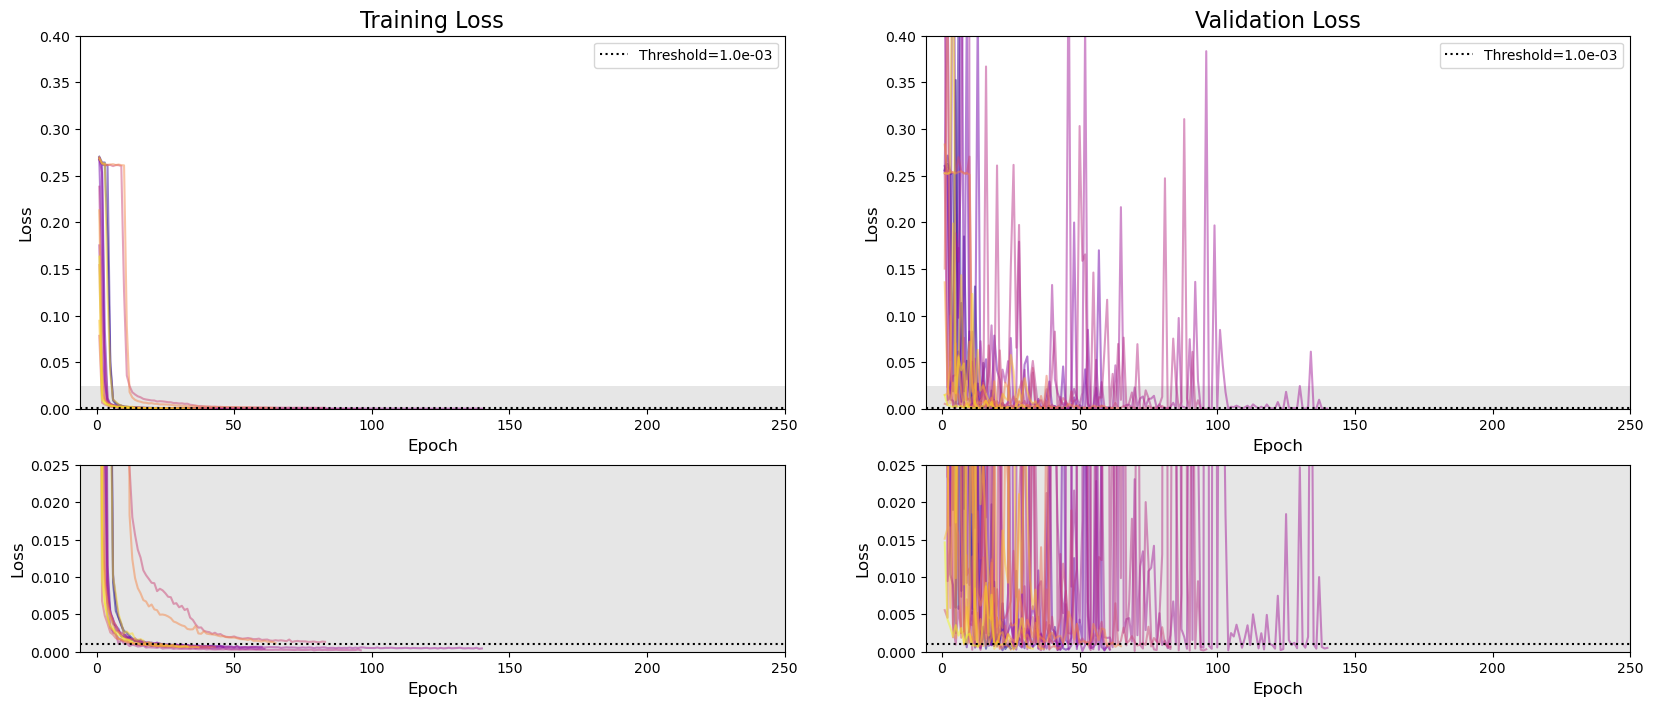

In [10]:
directory = os.path.abspath('../CNN_Models')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, height_ratios=[2, 1], figsize=(20, 8))
#fig.suptitle('CNN Identical Parameter Variance', fontsize=18)
colors = plt.get_cmap('plasma')
face_color = str(0.9)
plot_cutoff = 0.4
subplot_cuttoff = 0.025
spacing = np.linspace(0, 1, len(cnn_studies.index), endpoint=True)
total_max_epoch = 0

for i, SID in enumerate(cnn_studies.index):

    cnn_summary_data, _ = parse_dfs(directory=directory, studyID=SID, studies_df=cnn_studies, update_studies=False, verbose=False)
    
    study_max_epoch = cnn_summary_data.index.max()
    total_max_epoch = max(total_max_epoch, study_max_epoch)
    TTE_epoch = cnn_studies.loc[SID, 'TTE']
    ax1.plot(np.arange(1, TTE_epoch+1), cnn_summary_data['train_loss'][:TTE_epoch], alpha=0.5, color=colors(spacing[i]))
    ax2.plot(np.arange(1, TTE_epoch+1), cnn_summary_data['val_loss'][:TTE_epoch], alpha=0.5, color=colors(spacing[i]))

    ax3.plot(np.arange(1, TTE_epoch+1), cnn_summary_data['train_loss'][:TTE_epoch], alpha=0.5, color=colors(spacing[i]))
    ax4.plot(np.arange(1, TTE_epoch+1), cnn_summary_data['val_loss'][:TTE_epoch], alpha=0.5, color=colors(spacing[i]))


legend_elements = [mpl.lines.Line2D([0], [0], ls=':', color='k', alpha=1, label='Threshold={:.1e}'.format(threshold))]

ax1.set_title('Training Loss', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_xticks(np.arange(0, total_max_epoch+1, 50))
ax1.axhline(threshold, ls=':', color='k')
ax1.set_ylim([0, plot_cutoff])
ax1.legend(handles=legend_elements)
shaded_epochs = mpl.patches.Rectangle((-100, 0), total_max_epoch+200, subplot_cuttoff, facecolor=face_color)
ax1.add_patch(shaded_epochs)

ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Loss', fontsize=12)
ax3.set_xticks(np.arange(0, total_max_epoch+1, 50))
ax3.axhline(threshold, ls=':', color='k')
ax3.set_ylim([0, subplot_cuttoff])
ax3.set_facecolor(face_color)

ax2.set_title('Validation Loss', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_xticks(np.arange(0, total_max_epoch+1, 50))
ax2.axhline(threshold, ls=':', color='k')
ax2.set_ylim([0, plot_cutoff])
ax2.legend(handles=legend_elements)
shaded_epochs = mpl.patches.Rectangle((-100, 0), total_max_epoch+200, subplot_cuttoff, facecolor=face_color)
ax2.add_patch(shaded_epochs)

ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Loss', fontsize=12)
ax4.set_xticks(np.arange(0, total_max_epoch+1, 50))
ax4.axhline(threshold, ls=':', color='k')
ax4.set_ylim([0, subplot_cuttoff])
ax4.set_facecolor(face_color)
#fig.savefig('../figures/cnn_histories.png');

### CNN Depth Study

## Comparing CNNs and ViTs

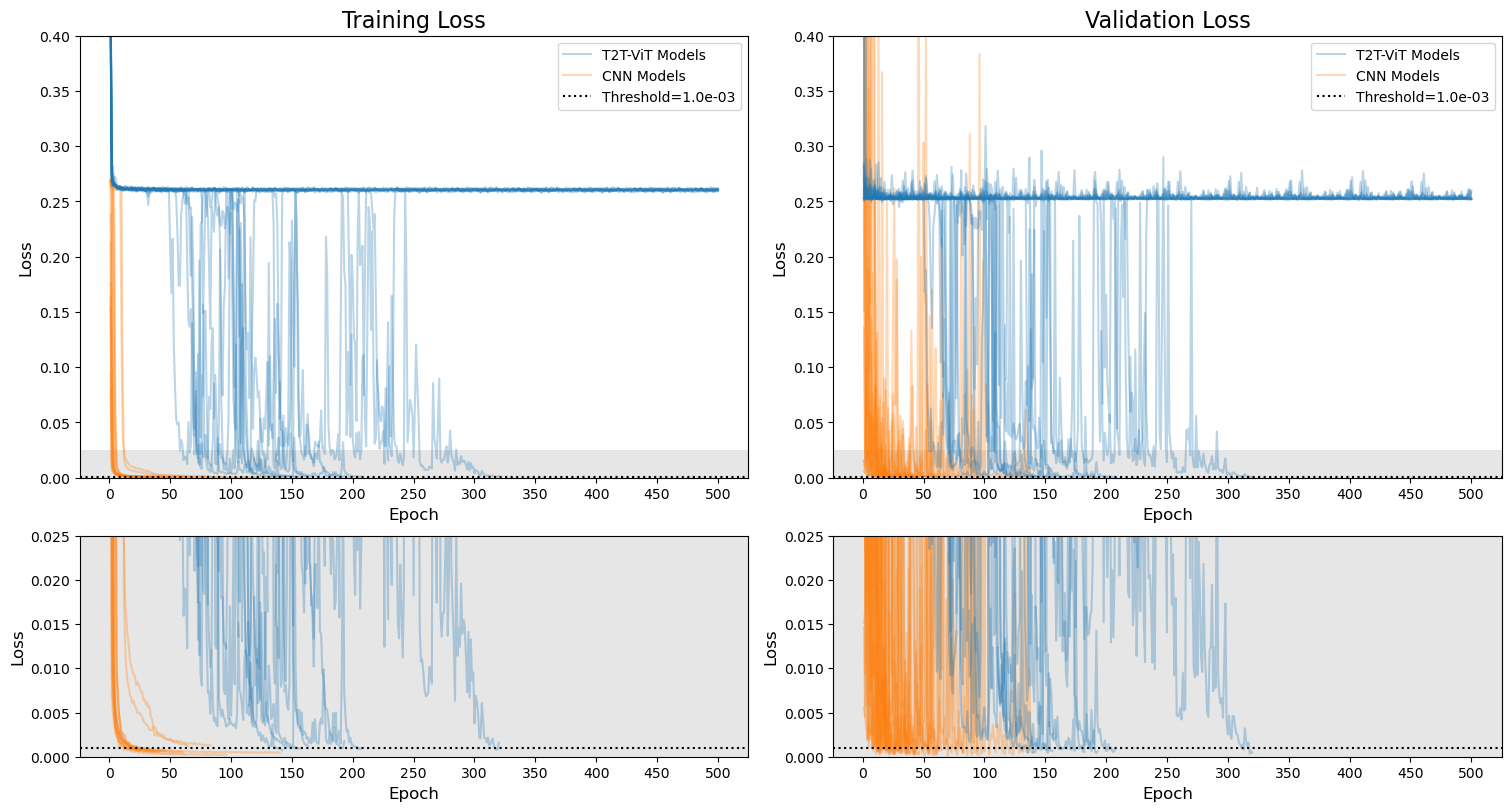

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, height_ratios=[2, 1], figsize=(15,8), layout='constrained')
#fig.suptitle('All Models', fontsize=20)
face_color = str(0.9)
alpha = 0.3
plot_cutoff = 0.4
subplot_cuttoff = 0.025
total_max_epoch = 0

directory = os.path.abspath('../CNN_Models')
for i, SID in enumerate(cnn_studies.index):
    cnn_summary_data, _ = parse_dfs(directory=directory, studyID=SID, studies_df=cnn_studies, update_studies=False, verbose=False)
    
    study_max_epoch = cnn_summary_data.index.max()
    total_max_epoch = max(total_max_epoch, study_max_epoch)
    TTE_epoch = cnn_studies.loc[SID, 'TTE']
    ax1.plot(np.arange(1, TTE_epoch+1), cnn_summary_data['train_loss'][:TTE_epoch], alpha=alpha, color='C1')
    ax2.plot(np.arange(1, TTE_epoch+1), cnn_summary_data['val_loss'][:TTE_epoch], alpha=alpha, color='C1')

    ax3.plot(np.arange(1, TTE_epoch+1), cnn_summary_data['train_loss'][:TTE_epoch], alpha=alpha, color='C1')
    ax4.plot(np.arange(1, TTE_epoch+1), cnn_summary_data['val_loss'][:TTE_epoch], alpha=alpha, color='C1')


directory = os.path.abspath('../T2T_ViT_Models')
for i, SID in enumerate(t2t_studies.index):

    t2t_summary_data, _ = parse_dfs(directory=directory, studyID=SID, studies_df=t2t_studies, update_studies=False, verbose=False)
    
    study_max_epoch = t2t_summary_data.index.max()
    total_max_epoch = max(total_max_epoch, study_max_epoch)
    TTE_epoch = t2t_studies.loc[SID, 'TTE']
    ax1.plot(np.arange(1, TTE_epoch+1), t2t_summary_data['train_loss'][:TTE_epoch], alpha=alpha, color='C0')
    ax2.plot(np.arange(1, TTE_epoch+1), t2t_summary_data['val_loss'][:TTE_epoch], alpha=alpha, color='C0')

    ax3.plot(np.arange(1, TTE_epoch+1), t2t_summary_data['train_loss'][:TTE_epoch], alpha=alpha, color='C0')
    ax4.plot(np.arange(1, TTE_epoch+1), t2t_summary_data['val_loss'][:TTE_epoch], alpha=alpha, color='C0')

legend_elements = [mpl.lines.Line2D([0], [0], color='C0', alpha=alpha, label='T2T-ViT Models'),
                   mpl.lines.Line2D([0], [0], color='C1', alpha=alpha, label='CNN Models'),
                   mpl.lines.Line2D([0], [0], ls=':', color='k', alpha=1, label='Threshold={:.1e}'.format(threshold))]
                   

ax1.set_title('Training Loss', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_xticks(np.arange(0, total_max_epoch+1, 50))
ax1.axhline(threshold, ls=':', color='k')
ax1.set_ylim([0, plot_cutoff])
ax1.legend(handles=legend_elements)
shaded_epochs = mpl.patches.Rectangle((-100, 0), total_max_epoch+200, subplot_cuttoff, facecolor=face_color)
ax1.add_patch(shaded_epochs)

ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Loss', fontsize=12)
ax3.set_xticks(np.arange(0, total_max_epoch+1, 50))
ax3.axhline(threshold, ls=':', color='k')
ax3.set_ylim([0, subplot_cuttoff])
ax3.set_facecolor(face_color)

ax2.set_title('Validation Loss', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_xticks(np.arange(0, total_max_epoch+1, 50))
ax2.axhline(threshold, ls=':', color='k')
ax2.set_ylim([0, plot_cutoff])
ax2.legend(handles=legend_elements)
shaded_epochs = mpl.patches.Rectangle((-100, 0), total_max_epoch+200, subplot_cuttoff, facecolor=face_color)
ax2.add_patch(shaded_epochs)

ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Loss', fontsize=12)
ax4.set_xticks(np.arange(0, total_max_epoch+1, 50))
ax4.axhline(threshold, ls=':', color='k')
ax4.set_ylim([0, subplot_cuttoff])
ax4.set_facecolor(face_color)

#fig.savefig('../figures/allmodels_histories.png');

In [12]:
## Compare Best Accuracy
print('The best T2T-ViT model achieved loss of {:e} at checkpoint {}.'.format(t2t_best.loc['CHKPT_TEST'], t2t_best.loc['BEST_CHKPT']))
print('The best CNN model achieved loss of {:e} at checkpoint {}.'.format(cnn_best.loc['CHKPT_TEST'], cnn_best.loc['BEST_CHKPT']))

The best T2T-ViT model achieved loss of 1.124338e-04 at checkpoint 400.
The best CNN model achieved loss of 5.521546e-05 at checkpoint 200.


In [13]:
## Compare Train Time
t2t_avg_total_time = np.mean(t2t_studies['TOTAL_TIME (hr)'])
t2t_avg_epoch_time = np.mean(t2t_studies['AVG_EPOCH_TIME (min)'])
print('The T2T-ViT models took an average of {} hours to train {} epochs (across all studies).'.format(round(t2t_avg_total_time,2), t2t_summary_data.index.max()))
print('That amounts to an average of {} minutes per epoch (across all studies).'.format(round(t2t_avg_epoch_time,2)))

print('\n')
cnn_avg_total_time = np.mean(cnn_studies['TOTAL_TIME (hr)'])
cnn_avg_epoch_time = np.mean(cnn_studies['AVG_EPOCH_TIME (min)'])
print('The CNN models took an average of {} hours to train {} epochs (across all studies).'.format(round(cnn_avg_total_time,2), cnn_summary_data.index.max()))
print('That amounts to an average of {} minutes per epoch (across all studies).'.format(round(cnn_avg_epoch_time,2)))

The T2T-ViT models took an average of 60.91 hours to train 500 epochs (across all studies).
That amounts to an average of 7.31 minutes per epoch (across all studies).


The CNN models took an average of 31.61 hours to train 250 epochs (across all studies).
That amounts to an average of 7.59 minutes per epoch (across all studies).


In [14]:
## Compare Number of Parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [15]:
t2t_model = T2T_ViT(img_size = (1, 1700, 500),
					softsplit_kernels = (31, 3, 3),
					preds = 1,
					token_len = 1024,
					token_chan = 64,
					num_heads = 4,
					T2T_hidden_chan_mul = 1.0,
					Encoding_hidden_chan_mul = 1.0,
					depth = 12,
					qkv_bias = False,
					qk_scale = None,
					act_layer = nn.GELU,
					norm_layer = nn.LayerNorm)

cnn_model = CNN(img_size = (1, 1700, 500),
				size_threshold = (8, 8),
				kernel = 5,
				features = 12, 
				interp_depth = 3,
				act_layer = nn.GELU,
				hidden_features = 20)

In [16]:
t2t_params = count_parameters(t2t_model)
print('The T2T-ViT Model has {:e} trainable parameters.'.format(t2t_params))
cnn_params = count_parameters(cnn_model)
print('The CNN Model has {:e} trainable parameters.'.format(cnn_params))

print('\n')
t2t_encode_params = count_parameters(t2t_model.vit_backbone.blocks[0])
print('Each encoding block in the T2T-ViT Model has {:e} trainable parameters.'.format(t2t_encode_params))
cnn_conv_params = count_parameters(cnn_model.interp_module.interpConv[0]) + count_parameters(cnn_model.interp_module.interpNorms[0]) + count_parameters(cnn_model.interp_module.interpActivations[0])
print('Each interpretability block in the CNN Model has {:e} trainable parameters.'.format(cnn_conv_params))

The T2T-ViT Model has 7.650183e+07 trainable parameters.
The CNN Model has 5.934500e+04 trainable parameters.


Each encoding block in the T2T-ViT Model has 6.298624e+06 trainable parameters.
Each interpretability block in the CNN Model has 3.636000e+03 trainable parameters.


## Time-To-Event Analysis

### T2T-ViT Models

In [17]:
## Kaplan-Meier Estimator
t2t_kmf = lifelines.KaplanMeierFitter()
t2t_kmf.fit(durations=t2t_studies['TTE'].to_numpy(dtype=np.float32), event_observed=t2t_studies['OCCURED'].to_numpy(dtype=np.float32))
t2t_kmf_sf = t2t_kmf.survival_function_ #survival function
t2t_kmf_cif = 1 - t2t_kmf_sf #cumulative incidence function

## Nelson-Aalen Estimator
t2t_naf = lifelines.NelsonAalenFitter()
t2t_naf.fit(durations=t2t_studies['TTE'].to_numpy(dtype=np.float32), event_observed=t2t_studies['OCCURED'].to_numpy(dtype=np.float32))
t2t_naf_hf = t2t_naf.cumulative_hazard_ #hazard function
t2t_naf_cif = 1 - np.exp(-t2t_naf_hf) #cumulative incidence function

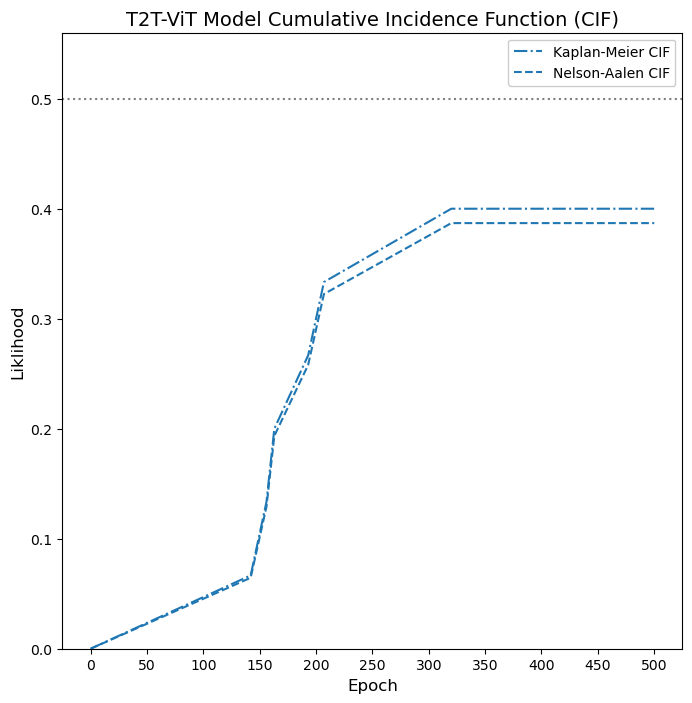

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('T2T-ViT Model Cumulative Incidence Function (CIF)', fontsize=14)
ax.plot(t2t_kmf_cif, ls='-.', color='C0', label='Kaplan-Meier CIF')
ax.plot(t2t_naf_cif, ls='--', color='C0', label='Nelson-Aalen CIF')
ax.axhline(0.5, ls=':', color='k', alpha=0.5)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Liklihood', fontsize=12)
ax.set_xticks(np.arange(0, 500+1, 50))
ax.set_ylim([0, 0.56])
ax.set_yticks(np.arange(0, 0.55, 0.1))
ax.legend(loc='upper right', framealpha=1);
#fig.savefig('./paper_figures/t2tvit_cif.png');

### CNN Models

In [19]:
## Kaplan-Meier Estimator
cnn_kmf = lifelines.KaplanMeierFitter()
cnn_kmf.fit(durations=cnn_studies['TTE'].to_numpy(dtype=np.float32), event_observed=cnn_studies['OCCURED'].to_numpy(dtype=np.float32))
cnn_kmf_sf = cnn_kmf.survival_function_ #survival function
cnn_kmf_cif = 1 - cnn_kmf_sf #cumulative incidence function

## Nelson-Aalen Estimator
cnn_naf = lifelines.NelsonAalenFitter()
cnn_naf.fit(durations=cnn_studies['TTE'].to_numpy(dtype=np.float32), event_observed=cnn_studies['OCCURED'].to_numpy(dtype=np.float32))
cnn_naf_hf = cnn_naf.cumulative_hazard_ #hazard function
cnn_naf_cif = 1 - np.exp(-cnn_naf_hf) #cumulative incidence function

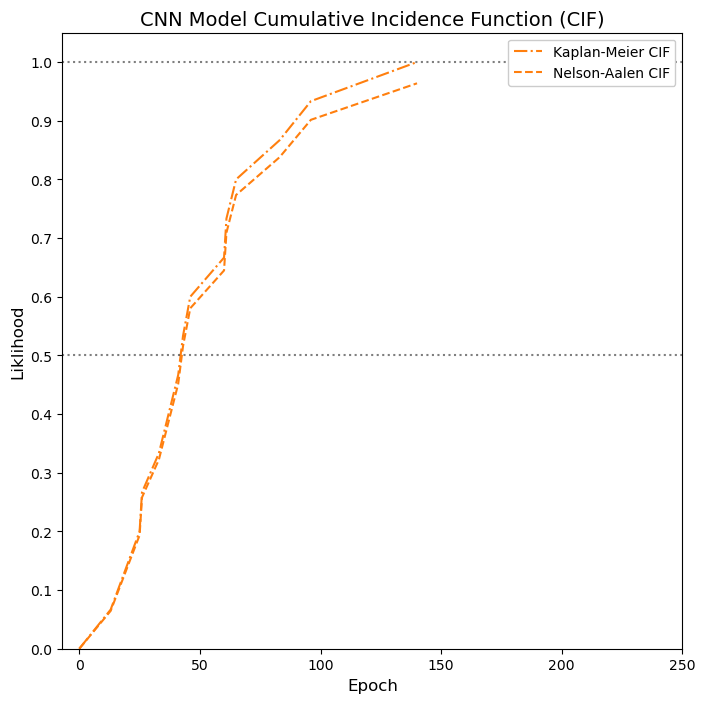

In [20]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('CNN Model Cumulative Incidence Function (CIF)', fontsize=14)
ax.plot(cnn_kmf_cif, ls='-.', color='C1', label='Kaplan-Meier CIF')
ax.plot(cnn_naf_cif, ls='--', color='C1', label='Nelson-Aalen CIF')
ax.axhline(0.5, ls=':', color='k', alpha=0.5)
ax.axhline(1.0, ls=':', color='k', alpha=0.5)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Liklihood', fontsize=12)
ax.set_xticks(np.arange(0, 250+1, 50))
ax.set_ylim([0, 1.05])
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.legend(loc='upper right', framealpha=1);
#fig.savefig('./paper_figures/cnn_cif.png');

### Model Comparison

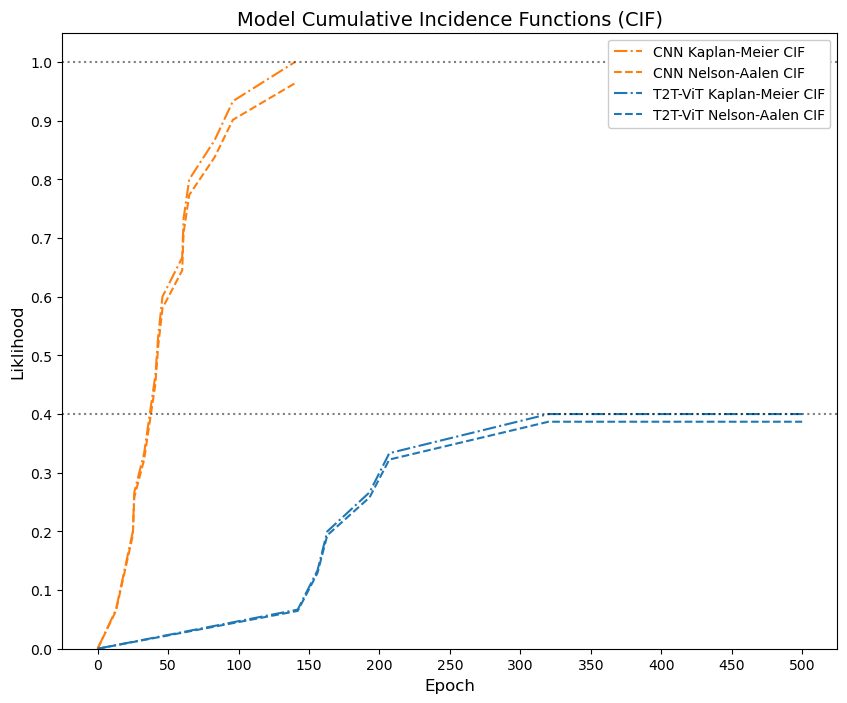

In [23]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title('Model Cumulative Incidence Functions (CIF)', fontsize=14)
ax.plot(cnn_kmf_cif, ls='-.', color='C1', label='CNN Kaplan-Meier CIF')
ax.plot(cnn_naf_cif, ls='--', color='C1', label='CNN Nelson-Aalen CIF')
ax.plot(t2t_kmf_cif, ls='-.', color='C0', label='T2T-ViT Kaplan-Meier CIF')
ax.plot(t2t_naf_cif, ls='--', color='C0', label='T2T-ViT Nelson-Aalen CIF')
ax.axhline(0.4, ls=':', color='k', alpha=0.5)
ax.axhline(1.0, ls=':', color='k', alpha=0.5)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Liklihood', fontsize=12)
ax.set_xticks(np.arange(0, 500+1, 50))
ax.set_ylim([0, 1.05])
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.legend(loc='upper right', framealpha=1);
#fig.savefig('../figures/allmodels_cif.png');